In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import torch_geometric.transforms as T
import GCN as G

from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm

/lhome/ific/l/lopezneu/ific108/software/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
store  = pd.HDFStore("jobs_aux/None_None/Loss_GCN.h5")
y_test = store['y_test']
y_pred = store['y_predict_test']
y_pred = np.exp(y_pred)/(1+np.exp(y_pred))

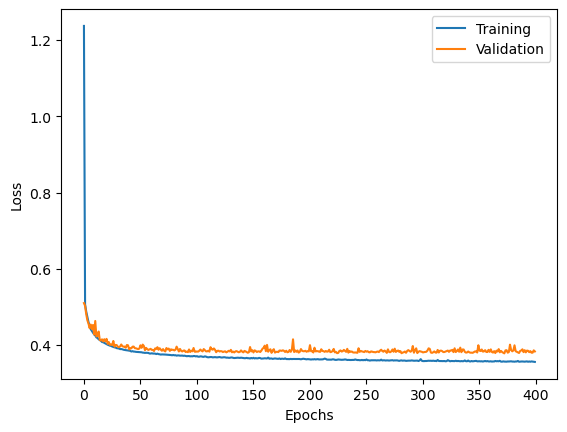

In [3]:
plt.plot(store['loss_train'],label='Training')
plt.plot(store['loss_valid'],label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0,1])
plt.legend()

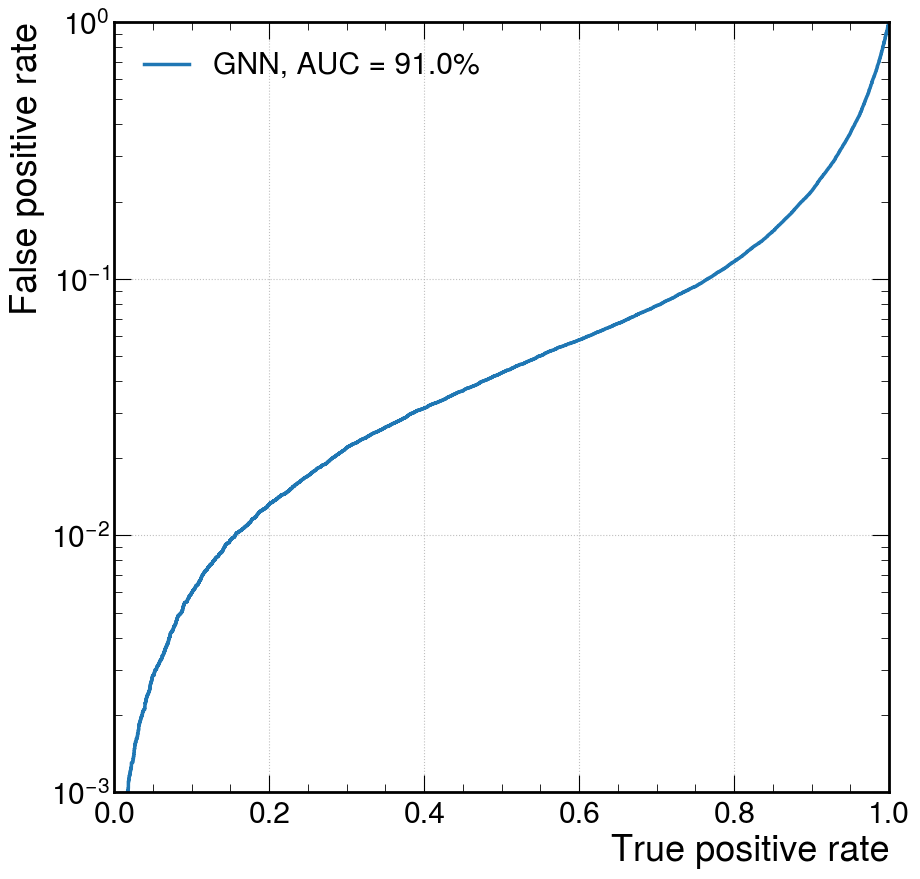

In [4]:
plt.style.use(hep.style.ROOT)
# create ROC curves
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
    
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

  0%|          | 0/110963 [00:00<?, ?it/s]

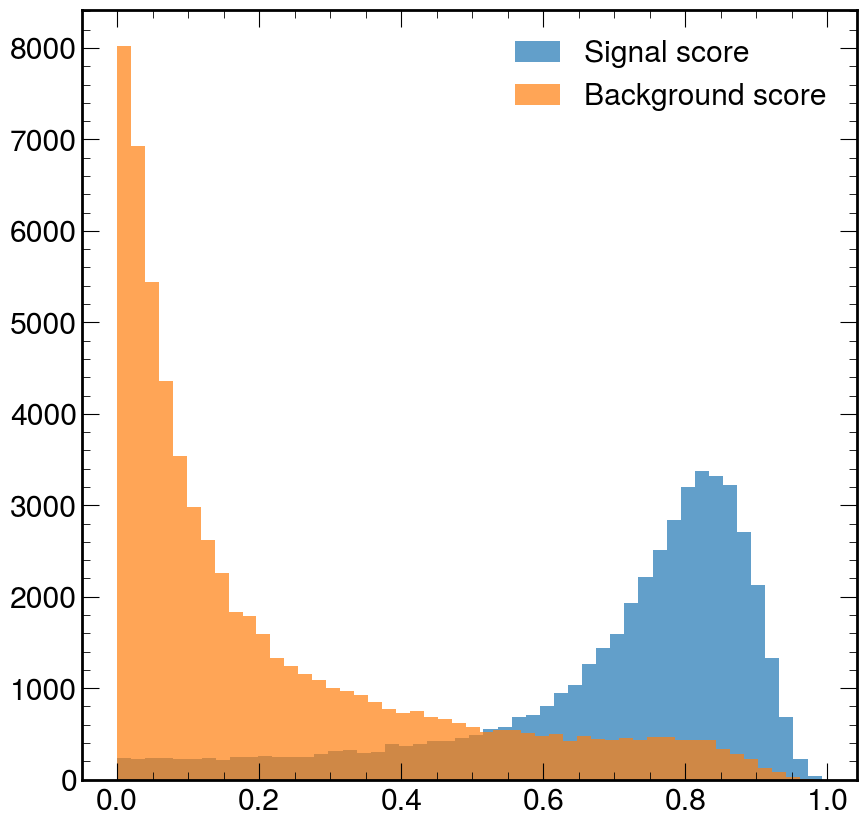

In [5]:
B_score = []
S_score = []
t = tqdm(range(0, len(y_pred)))

for i in t:
    if y_test.to_numpy()[i][0]==0:
        B_score.append(y_pred.to_numpy()[i][0])
    else:
        S_score.append(y_pred.to_numpy()[i][0])
        
plt.hist(S_score, 50, label='Signal score', alpha=0.7)
plt.hist(B_score, 50, label='Background score', alpha=0.7)
plt.legend()

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/fkellere/ipykernel_115754/4036247501.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/


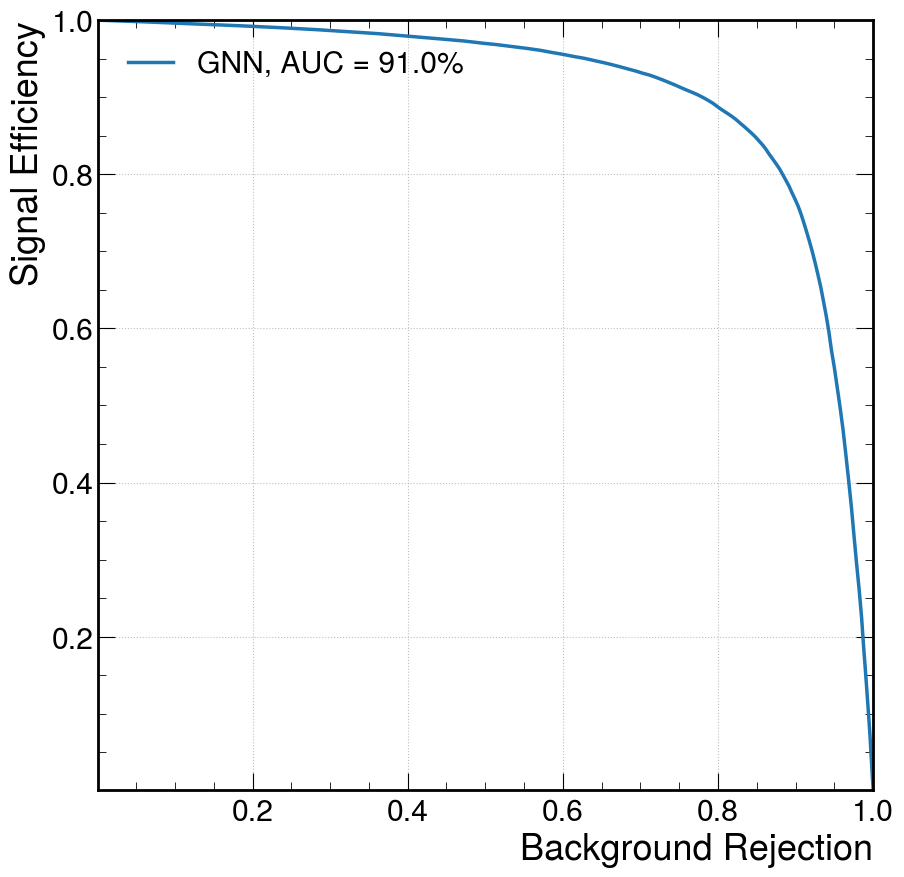

In [6]:
Seff = []
Brej = []
Figm = []
thre = np.linspace(min(y_pred.to_numpy()),max(y_pred.to_numpy()),100)
t    = tqdm(range(0,len(thre)))

for i in t:
    Seff.append(len([x for x in S_score if x>=thre[i]])/len(S_score))
    Brej.append(1-len([x for x in B_score if x>=thre[i]])/len(B_score))
    Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/
            (np.sqrt(len([x for x in B_score if x>=thre[i]]))*len(S_score)))
    
plt.figure()
plt.plot(Brej, Seff, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc(Brej,Seff)*100))
plt.xlabel(r'Background Rejection')
plt.ylabel(r'Signal Efficiency')
#plt.semilogx()
plt.ylim(0.001, 1)
plt.xlim(0.001, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

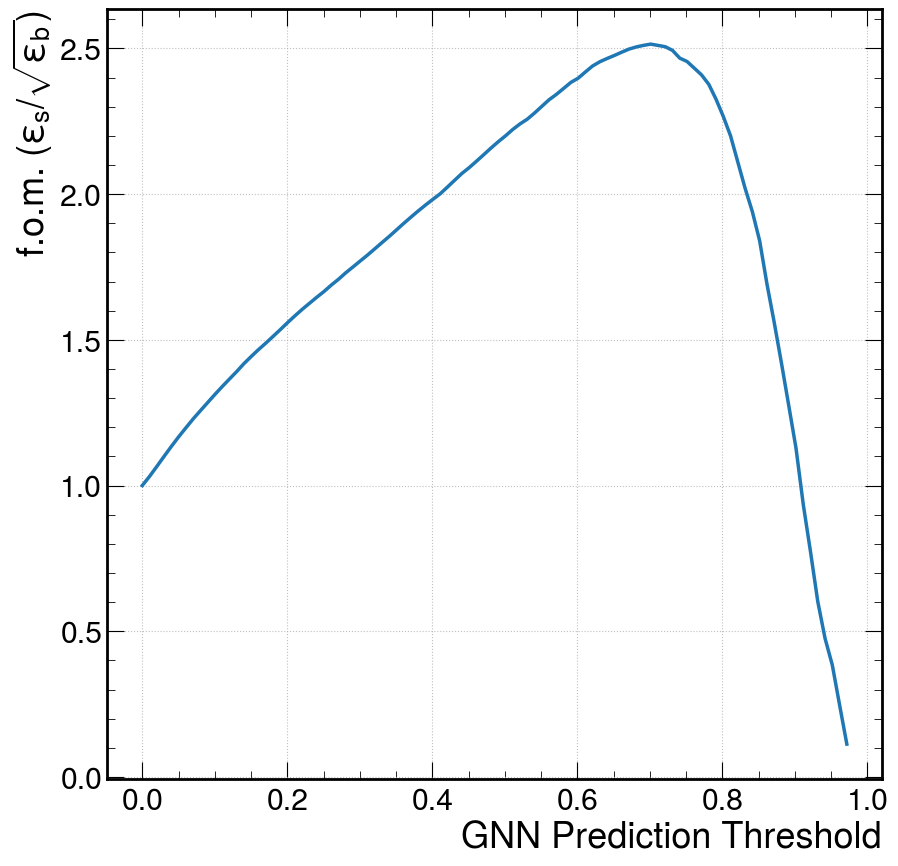

In [7]:
plt.figure()
plt.plot(thre, Figm, lw=2.5)
plt.xlabel(r'GNN Prediction Threshold')
plt.ylabel(r'f.o.m. ($\epsilon_{s}/\sqrt{\epsilon_{b}}$)')
plt.grid(True)
plt.show()

In [8]:
Fom  = [x for x in Figm if x!=np.inf]
Seff[np.argmax(Fom)]

0.6535033739337096

In [9]:
Brej[np.argmax(Fom)]

0.9324842959412253

In [10]:
max(Fom)

2.5150431102474395

In [11]:
thre_GCN = thre
Figm_GCN = Figm
Seff_GCN = Seff
Brej_GCN = Brej
%store thre_GCN
%store Figm_GCN
%store Seff_GCN
%store Brej_GCN

Stored 'thre_GCN' (ndarray)
Stored 'Figm_GCN' (list)
Stored 'Seff_GCN' (list)
Stored 'Brej_GCN' (list)


In [12]:
y_pred.Event[33]

0.70341045